In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'silu',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

silu_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 831)
(631390, 1)
validation
(74368, 831)
(74368, 1)
test
(85358, 831)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1541121 (5.88 MB)


Trainable params: 1541121 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:16 - loss: 0.0838 - STD: 0.0060 - MAE: 0.2801

 5/64 [=>............................] - ETA: 0s - loss: 0.0397 - STD: 0.0130 - MAE: 0.1678  

 9/64 [===>..........................] - ETA: 0s - loss: 0.0275 - STD: 0.0168 - MAE: 0.1230

13/64 [=====>........................] - ETA: 0s - loss: 0.0217 - STD: 0.0257 - MAE: 0.1052

17/64 [======>.......................] - ETA: 0s - loss: 0.0181 - STD: 0.0430 - MAE: 0.0937

20/64 [========>.....................] - ETA: 0s - loss: 0.0162 - STD: 0.0499 - MAE: 0.0875

24/64 [==========>...................] - ETA: 0s - loss: 0.0143 - STD: 0.0550 - MAE: 0.0805

28/64 [============>.................] - ETA: 0s - loss: 0.0129 - STD: 0.0606 - MAE: 0.0750

32/64 [==============>...............] - ETA: 0s - loss: 0.0117 - STD: 0.0639 - MAE: 0.0705

36/64 [===============>..............] - ETA: 0s - loss: 0.0108 - STD: 0.0678 - MAE: 0.0669

40/64 [=================>............] - ETA: 0s - loss: 0.0101 - STD: 0.0712 - MAE: 0.0640

44/64 [===================>..........] - ETA: 0s - loss: 0.0096 - STD: 0.0729 - MAE: 0.0614

48/64 [=====================>........] - ETA: 0s - loss: 0.0090 - STD: 0.0752 - MAE: 0.0593

52/64 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 0.0772 - MAE: 0.0575

56/64 [=========================>....] - ETA: 0s - loss: 0.0081 - STD: 0.0784 - MAE: 0.0558

60/64 [===========================>..] - ETA: 0s - loss: 0.0078 - STD: 0.0797 - MAE: 0.0544

64/64 [==============================] - ETA: 0s - loss: 0.0075 - STD: 0.0811 - MAE: 0.0531

64/64 [==============================] - 3s 32ms/step - loss: 0.0075 - STD: 0.0811 - MAE: 0.0531 - val_loss: 0.0034 - val_STD: 0.0753 - val_MAE: 0.0368


Epoch 2/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0023 - STD: 0.0970 - MAE: 0.0317

 4/64 [>.............................] - ETA: 1s - loss: 0.0024 - STD: 0.1013 - MAE: 0.0324

 8/64 [==>...........................] - ETA: 0s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0323

12/64 [====>.........................] - ETA: 0s - loss: 0.0024 - STD: 0.1014 - MAE: 0.0322

16/64 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.1016 - MAE: 0.0321

20/64 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.1014 - MAE: 0.0320

24/64 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1020 - MAE: 0.0319

28/64 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0317

32/64 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1022 - MAE: 0.0316

37/64 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0315

41/64 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0314

45/64 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0313

49/64 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0312

53/64 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1025 - MAE: 0.0313

57/64 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1026 - MAE: 0.0312

61/64 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0311

64/64 [==============================] - 1s 18ms/step - loss: 0.0021 - STD: 0.1027 - MAE: 0.0311 - val_loss: 0.0020 - val_STD: 0.0851 - val_MAE: 0.0306


Epoch 3/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.0943 - MAE: 0.0296

 5/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1022 - MAE: 0.0291

 9/64 [===>..........................] - ETA: 0s - loss: 0.0018 - STD: 0.1027 - MAE: 0.0289

13/64 [=====>........................] - ETA: 0s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0289

17/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0289

21/64 [========>.....................] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0292

25/64 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0293

29/64 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0293

33/64 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0294

36/64 [===============>..............] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0295

40/64 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0297

44/64 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0299

48/64 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0301

52/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0301

56/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0301

60/64 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0301

64/64 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0300

64/64 [==============================] - 1s 18ms/step - loss: 0.0020 - STD: 0.1031 - MAE: 0.0300 - val_loss: 0.0023 - val_STD: 0.0951 - val_MAE: 0.0331


Epoch 4/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1092 - MAE: 0.0283

 5/64 [=>............................] - ETA: 0s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0285

 9/64 [===>..........................] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0285

14/64 [=====>........................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0285

18/64 [=======>......................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0284

22/64 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0284

26/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0283

30/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0282

34/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0282

38/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0281

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0280

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0280

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0281

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0280

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0280

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0280

64/64 [==============================] - 1s 18ms/step - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281 - val_loss: 0.0022 - val_STD: 0.0957 - val_MAE: 0.0324


Epoch 5/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

 4/64 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0286

 8/64 [==>...........................] - ETA: 0s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0282

12/64 [====>.........................] - ETA: 0s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0277

16/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0276

20/64 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

24/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0275

32/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

36/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

44/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0284

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0286

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0286

64/64 [==============================] - 1s 17ms/step - loss: 0.0017 - STD: 0.1043 - MAE: 0.0286 - val_loss: 0.0024 - val_STD: 0.0996 - val_MAE: 0.0326


Epoch 6/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.1149 - MAE: 0.0286

 5/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1064 - MAE: 0.0285

 9/64 [===>..........................] - ETA: 0s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0282

13/64 [=====>........................] - ETA: 0s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0281

17/64 [======>.......................] - ETA: 0s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0280

21/64 [========>.....................] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0278

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0276

29/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0276

33/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

41/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

64/64 [==============================] - 1s 18ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272 - val_loss: 0.0017 - val_STD: 0.0947 - val_MAE: 0.0286


Epoch 7/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0267

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0271

 9/64 [===>..........................] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0272

13/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

17/64 [======>.......................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

21/64 [========>.....................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

29/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

33/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

41/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

64/64 [==============================] - 1s 18ms/step - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270 - val_loss: 0.0017 - val_STD: 0.0960 - val_MAE: 0.0283


Epoch 8/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0262

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0265

21/64 [========>.....................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

29/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

33/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

41/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

64/64 [==============================] - 1s 18ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273 - val_loss: 0.0016 - val_STD: 0.0955 - val_MAE: 0.0282


Epoch 9/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.0997 - MAE: 0.0258

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0258

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0260

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

64/64 [==============================] - 1s 18ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262 - val_loss: 0.0017 - val_STD: 0.0985 - val_MAE: 0.0282


Epoch 10/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1105 - MAE: 0.0264

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1073 - MAE: 0.0260

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0259

13/64 [=====>........................] - ETA: 0s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0276

18/64 [=======>......................] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0276

22/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0278

26/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0277

30/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

64/64 [==============================] - 1s 18ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267 - val_loss: 0.0018 - val_STD: 0.0969 - val_MAE: 0.0296


Epoch 11/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

64/64 [==============================] - 1s 18ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263 - val_loss: 0.0016 - val_STD: 0.0950 - val_MAE: 0.0280


Epoch 12/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0281

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1074 - MAE: 0.0261

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0270

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

64/64 [==============================] - 1s 18ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270 - val_loss: 0.0015 - val_STD: 0.0904 - val_MAE: 0.0275


Epoch 13/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.0998 - MAE: 0.0270

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0258

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0256

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0256

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

64/64 [==============================] - 1s 17ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257 - val_loss: 0.0017 - val_STD: 0.0982 - val_MAE: 0.0289


Epoch 14/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0251

 5/64 [=>............................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

 9/64 [===>..........................] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

13/64 [=====>........................] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

64/64 [==============================] - 1s 17ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256 - val_loss: 0.0018 - val_STD: 0.1007 - val_MAE: 0.0291


Epoch 15/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0254

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0258

 8/64 [==>...........................] - ETA: 0s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0256

12/64 [====>.........................] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0256

16/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0256

20/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

24/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0255

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

64/64 [==============================] - 1s 17ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268 - val_loss: 0.0022 - val_STD: 0.1005 - val_MAE: 0.0311


Epoch 16/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1105 - MAE: 0.0274

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0274

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

17/64 [======>.......................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

64/64 [==============================] - 1s 18ms/step - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261 - val_loss: 0.0016 - val_STD: 0.0974 - val_MAE: 0.0274


Epoch 17/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0246

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0249

 9/64 [===>..........................] - ETA: 0s - loss: 0.0013 - STD: 0.1076 - MAE: 0.0251

13/64 [=====>........................] - ETA: 0s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0250

18/64 [=======>......................] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0250

22/64 [=========>....................] - ETA: 0s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0250

26/64 [===========>..................] - ETA: 0s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0250

30/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

34/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

38/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

42/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

46/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

64/64 [==============================] - 1s 17ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252 - val_loss: 0.0016 - val_STD: 0.0896 - val_MAE: 0.0289


Epoch 18/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.0958 - MAE: 0.0258

 5/64 [=>............................] - ETA: 0s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0274

 9/64 [===>..........................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

13/64 [=====>........................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

17/64 [======>.......................] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

21/64 [========>.....................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

29/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

64/64 [==============================] - 1s 18ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253 - val_loss: 0.0014 - val_STD: 0.0963 - val_MAE: 0.0265


Epoch 19/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1032 - MAE: 0.0245

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0246

 9/64 [===>..........................] - ETA: 0s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0249

14/64 [=====>........................] - ETA: 0s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0249

18/64 [=======>......................] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0249

22/64 [=========>....................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0248

26/64 [===========>..................] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0248

30/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

34/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0249

38/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

42/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

46/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

64/64 [==============================] - 1s 17ms/step - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248 - val_loss: 0.0015 - val_STD: 0.0951 - val_MAE: 0.0267


Epoch 20/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1010 - MAE: 0.0253

 5/64 [=>............................] - ETA: 0s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0249

 9/64 [===>..........................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0246

13/64 [=====>........................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0246

17/64 [======>.......................] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0245

21/64 [========>.....................] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0245

25/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0246

29/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0249

33/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0253

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

45/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0291

49/64 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0339

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.1000 - MAE: 0.0409

58/64 [==========================>...] - ETA: 0s - loss: 0.0116 - STD: 0.1000 - MAE: 0.0574

62/64 [============================>.] - ETA: 0s - loss: 0.0135 - STD: 0.0947 - MAE: 0.0652

64/64 [==============================] - 1s 18ms/step - loss: 0.0143 - STD: 0.0931 - MAE: 0.0685 - val_loss: 0.2878 - val_STD: 0.0614 - val_MAE: 0.5289


Epoch 21/10000


 1/64 [..............................] - ETA: 3s - loss: 0.3129 - STD: 0.0789 - MAE: 0.5533

 5/64 [=>............................] - ETA: 0s - loss: 0.0843 - STD: 0.0344 - MAE: 0.2137

 9/64 [===>..........................] - ETA: 0s - loss: 0.0763 - STD: 0.0232 - MAE: 0.2228

13/64 [=====>........................] - ETA: 0s - loss: 0.0729 - STD: 0.0209 - MAE: 0.2261

17/64 [======>.......................] - ETA: 0s - loss: 0.0740 - STD: 0.0161 - MAE: 0.2327

21/64 [========>.....................] - ETA: 0s - loss: 0.0746 - STD: 0.0131 - MAE: 0.2367

25/64 [==========>...................] - ETA: 0s - loss: 0.0749 - STD: 0.0110 - MAE: 0.2394

29/64 [============>.................] - ETA: 0s - loss: 0.0752 - STD: 0.0095 - MAE: 0.2416

33/64 [==============>...............] - ETA: 0s - loss: 0.0754 - STD: 0.0083 - MAE: 0.2431

37/64 [================>.............] - ETA: 0s - loss: 0.0756 - STD: 0.0074 - MAE: 0.2443

41/64 [==================>...........] - ETA: 0s - loss: 0.0757 - STD: 0.0067 - MAE: 0.2452

45/64 [====================>.........] - ETA: 0s - loss: 0.0759 - STD: 0.0061 - MAE: 0.2460

49/64 [=====================>........] - ETA: 0s - loss: 0.0760 - STD: 0.0056 - MAE: 0.2467

53/64 [=======================>......] - ETA: 0s - loss: 0.0761 - STD: 0.0052 - MAE: 0.2472

57/64 [=========================>....] - ETA: 0s - loss: 0.0762 - STD: 0.0049 - MAE: 0.2477

61/64 [===========================>..] - ETA: 0s - loss: 0.0841 - STD: 0.0056 - MAE: 0.2558

64/64 [==============================] - 1s 17ms/step - loss: 0.1045 - STD: 0.0074 - MAE: 0.2769 - val_loss: 0.0846 - val_STD: 0.0038 - val_MAE: 0.2570


Epoch 22/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0762 - STD: 0.0135 - MAE: 0.2528

 5/64 [=>............................] - ETA: 0s - loss: 0.0770 - STD: 0.0027 - MAE: 0.2538

 9/64 [===>..........................] - ETA: 0s - loss: 0.0771 - STD: 0.0015 - MAE: 0.2539

13/64 [=====>........................] - ETA: 0s - loss: 0.0772 - STD: 0.0010 - MAE: 0.2540

17/64 [======>.......................] - ETA: 0s - loss: 0.0773 - STD: 7.9505e-04 - MAE: 0.2541

21/64 [========>.....................] - ETA: 0s - loss: 0.0772 - STD: 6.4361e-04 - MAE: 0.2540

25/64 [==========>...................] - ETA: 0s - loss: 0.0773 - STD: 5.4064e-04 - MAE: 0.2541

29/64 [============>.................] - ETA: 0s - loss: 0.0772 - STD: 4.6606e-04 - MAE: 0.2541

33/64 [==============>...............] - ETA: 0s - loss: 0.0773 - STD: 4.0957e-04 - MAE: 0.2541

37/64 [================>.............] - ETA: 0s - loss: 0.0773 - STD: 3.6529e-04 - MAE: 0.2541

42/64 [==================>...........] - ETA: 0s - loss: 0.0772 - STD: 3.2181e-04 - MAE: 0.2540

46/64 [====================>.........] - ETA: 0s - loss: 0.0772 - STD: 2.9382e-04 - MAE: 0.2540

50/64 [======================>.......] - ETA: 0s - loss: 0.0772 - STD: 2.7032e-04 - MAE: 0.2540

54/64 [========================>.....] - ETA: 0s - loss: 0.0772 - STD: 2.5029e-04 - MAE: 0.2540

58/64 [==========================>...] - ETA: 0s - loss: 0.0772 - STD: 2.3303e-04 - MAE: 0.2540

62/64 [============================>.] - ETA: 0s - loss: 0.0772 - STD: 2.1800e-04 - MAE: 0.2540

64/64 [==============================] - 1s 18ms/step - loss: 0.0772 - STD: 2.1119e-04 - MAE: 0.2540 - val_loss: 0.0857 - val_STD: 0.0000e+00 - val_MAE: 0.2579


Epoch 23/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0767 - STD: 0.0000e+00 - MAE: 0.2535

 6/64 [=>............................] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2539

10/64 [===>..........................] - ETA: 0s - loss: 0.0770 - STD: 0.0000e+00 - MAE: 0.2537

14/64 [=====>........................] - ETA: 0s - loss: 0.0771 - STD: 0.0000e+00 - MAE: 0.2538

18/64 [=======>......................] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2539

22/64 [=========>....................] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2540

26/64 [===========>..................] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2540

30/64 [=============>................] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2540

34/64 [==============>...............] - ETA: 0s - loss: 0.0773 - STD: 0.0000e+00 - MAE: 0.2540

38/64 [================>.............] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2540

42/64 [==================>...........] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2540

46/64 [====================>.........] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2540

50/64 [======================>.......] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2540

54/64 [========================>.....] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2540

58/64 [==========================>...] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2540

62/64 [============================>.] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2540

64/64 [==============================] - 1s 17ms/step - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2540 - val_loss: 0.0857 - val_STD: 0.0000e+00 - val_MAE: 0.2579


Epoch 24/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0761 - STD: 0.0000e+00 - MAE: 0.2524

 5/64 [=>............................] - ETA: 0s - loss: 0.0769 - STD: 0.0000e+00 - MAE: 0.2537

 9/64 [===>..........................] - ETA: 0s - loss: 0.0769 - STD: 0.0000e+00 - MAE: 0.2537

13/64 [=====>........................] - ETA: 0s - loss: 0.0771 - STD: 0.0000e+00 - MAE: 0.2538

17/64 [======>.......................] - ETA: 0s - loss: 0.0773 - STD: 0.0000e+00 - MAE: 0.2542

21/64 [========>.....................] - ETA: 0s - loss: 0.0771 - STD: 0.0000e+00 - MAE: 0.2539

25/64 [==========>...................] - ETA: 0s - loss: 0.0771 - STD: 0.0000e+00 - MAE: 0.2538

29/64 [============>.................] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2540

33/64 [==============>...............] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2540

37/64 [================>.............] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2540

41/64 [==================>...........] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2540

45/64 [====================>.........] - ETA: 0s - loss: 0.0771 - STD: 0.0000e+00 - MAE: 0.2539

49/64 [=====================>........] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2540

53/64 [=======================>......] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2541

57/64 [=========================>....] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2540

61/64 [===========================>..] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2540

64/64 [==============================] - 1s 17ms/step - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2540 - val_loss: 0.0857 - val_STD: 0.0000e+00 - val_MAE: 0.2579


Epoch 25/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2540

 5/64 [=>............................] - ETA: 0s - loss: 0.0769 - STD: 0.0000e+00 - MAE: 0.2536

 9/64 [===>..........................] - ETA: 0s - loss: 0.0768 - STD: 0.0000e+00 - MAE: 0.2535

13/64 [=====>........................] - ETA: 0s - loss: 0.0771 - STD: 0.0000e+00 - MAE: 0.2538

17/64 [======>.......................] - ETA: 0s - loss: 0.0770 - STD: 0.0000e+00 - MAE: 0.2538

21/64 [========>.....................] - ETA: 0s - loss: 0.0771 - STD: 0.0000e+00 - MAE: 0.2539

25/64 [==========>...................] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2539

29/64 [============>.................] - ETA: 0s - loss: 0.0771 - STD: 0.0000e+00 - MAE: 0.2538

33/64 [==============>...............] - ETA: 0s - loss: 0.0771 - STD: 0.0000e+00 - MAE: 0.2539

37/64 [================>.............] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2539

41/64 [==================>...........] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2539

45/64 [====================>.........] - ETA: 0s - loss: 0.0771 - STD: 0.0000e+00 - MAE: 0.2538

49/64 [=====================>........] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2539

53/64 [=======================>......] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2539

57/64 [=========================>....] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2539

61/64 [===========================>..] - ETA: 0s - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2540

64/64 [==============================] - 1s 17ms/step - loss: 0.0772 - STD: 0.0000e+00 - MAE: 0.2540 - val_loss: 0.0857 - val_STD: 0.0000e+00 - val_MAE: 0.2579


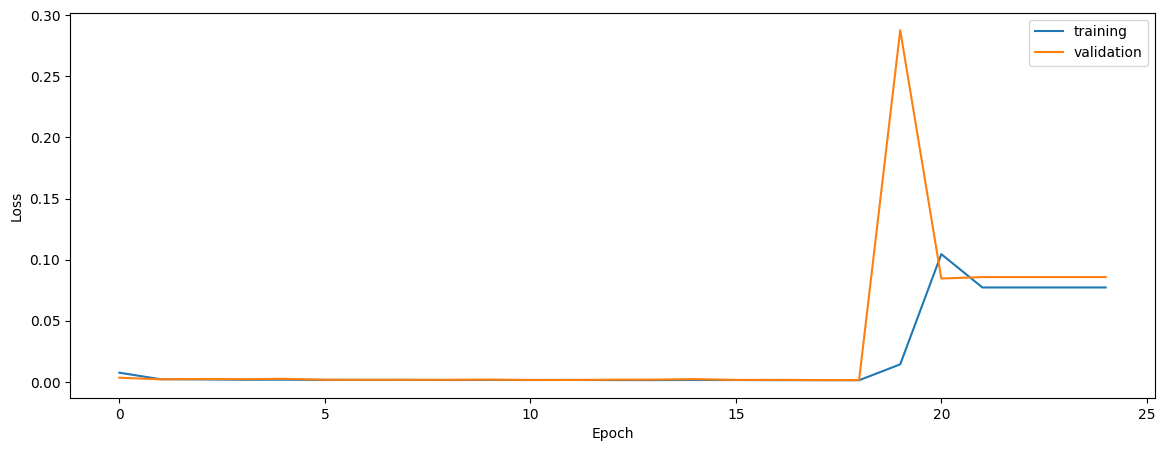

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9485682449807531
0.9575461115296722
0.9456940500694277


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9485682449807531
0.9575461115296722
0.9456940500694277


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9547224683462434
0.9599758750646314
0.957267207065967


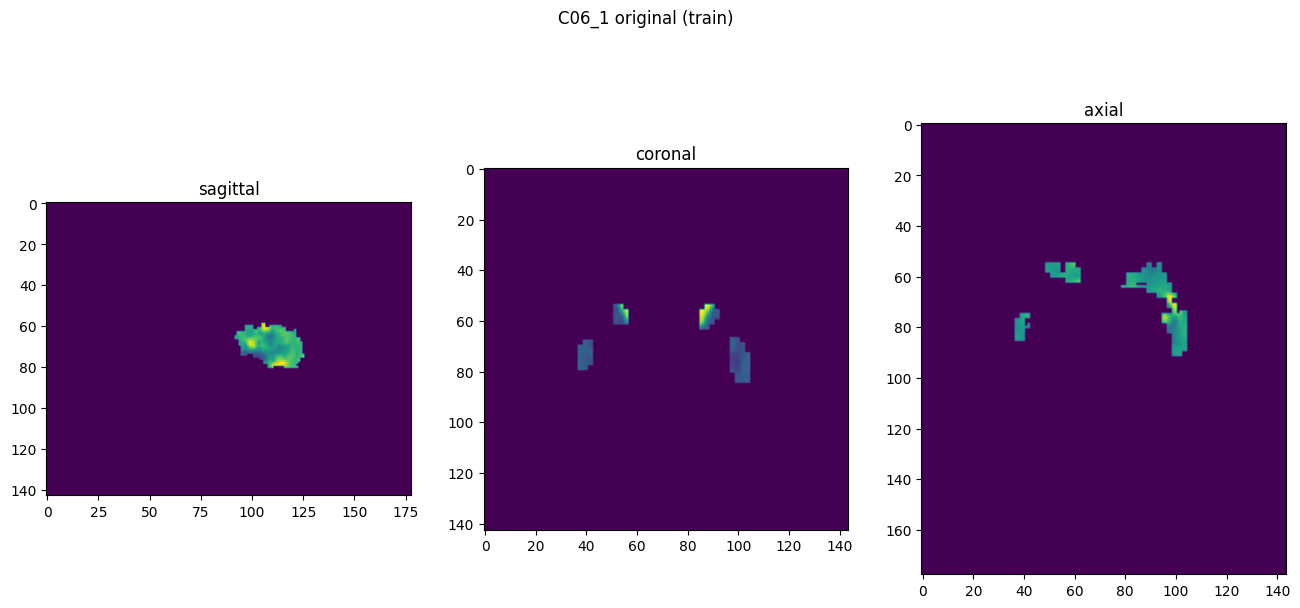

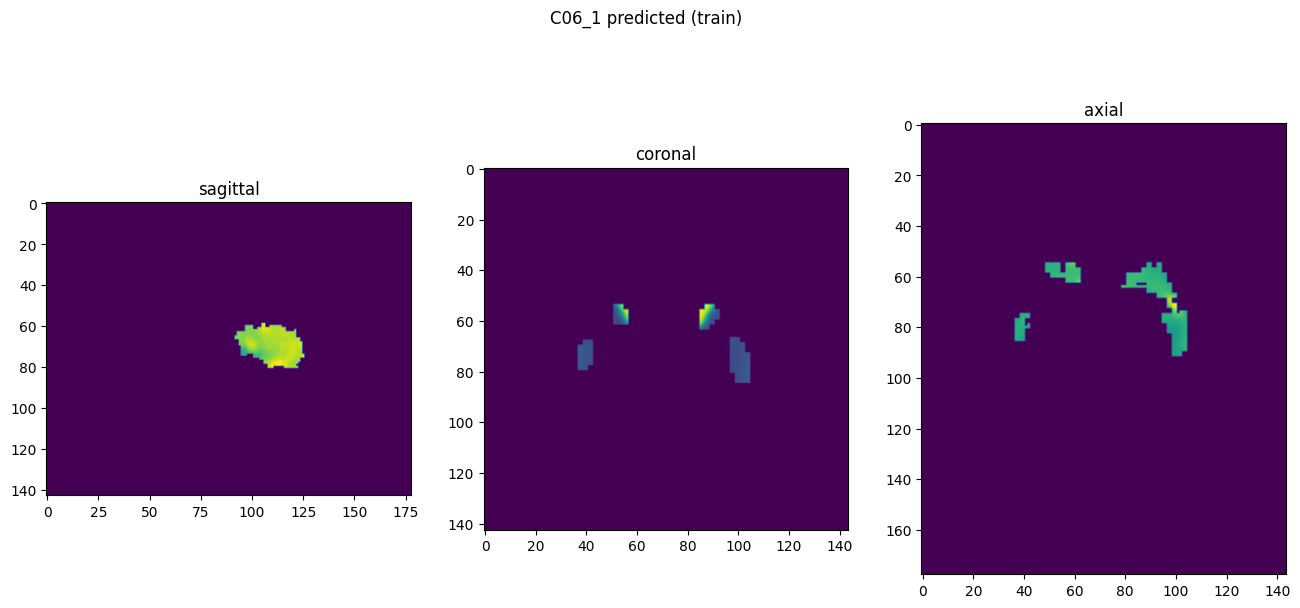

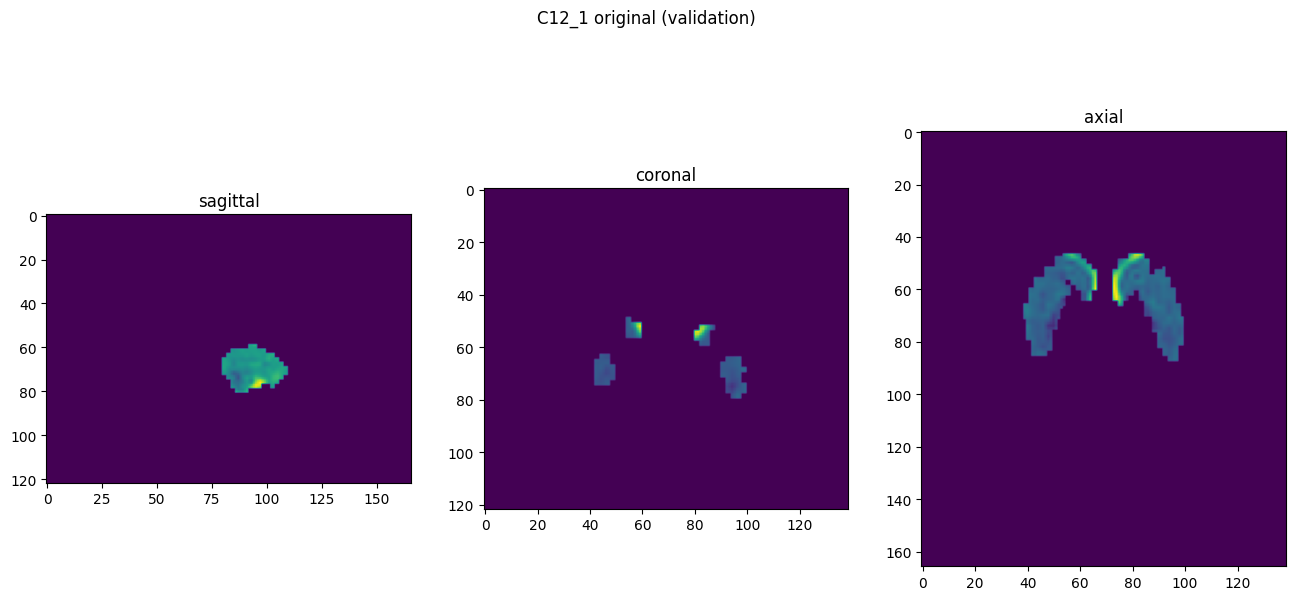

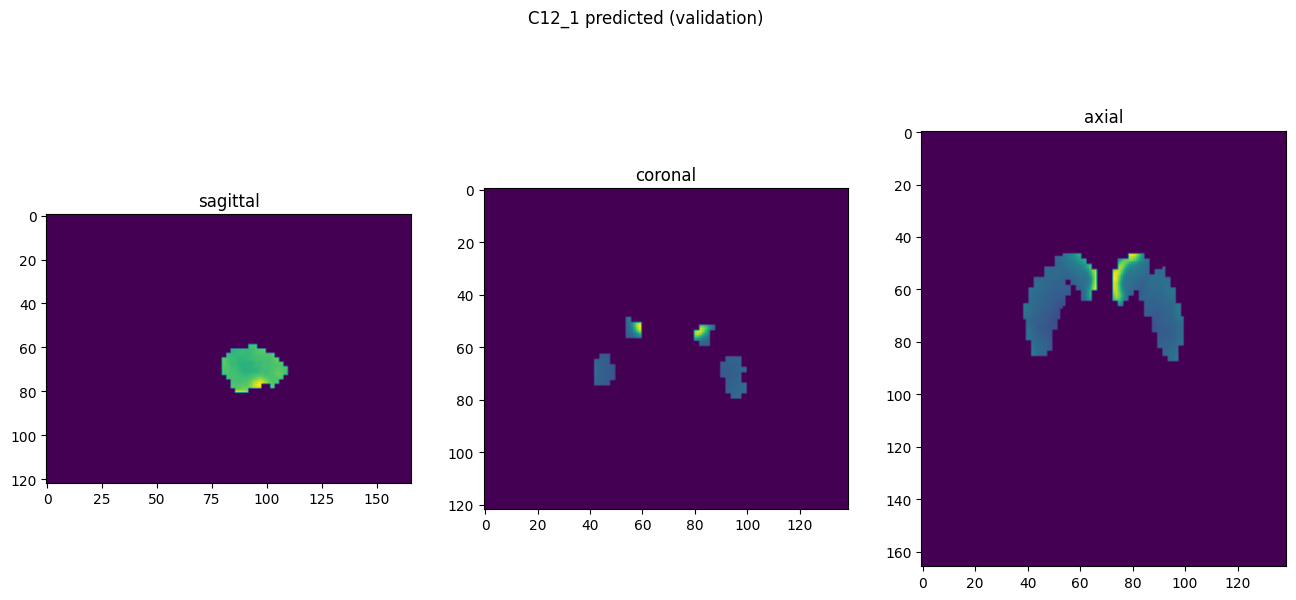

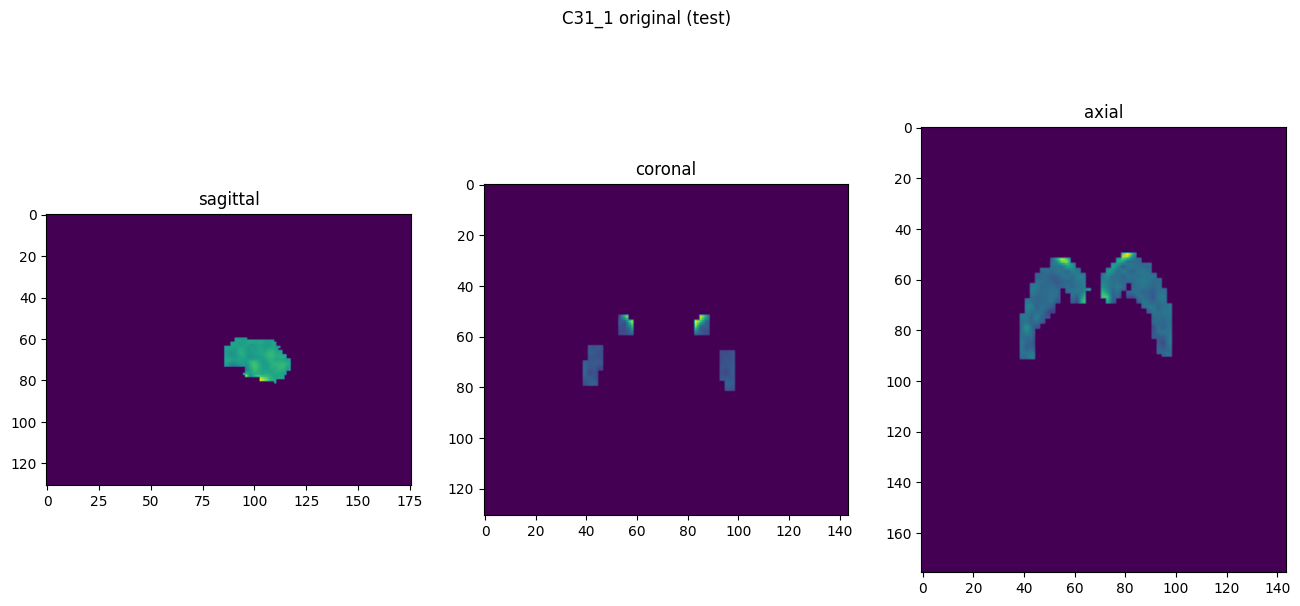

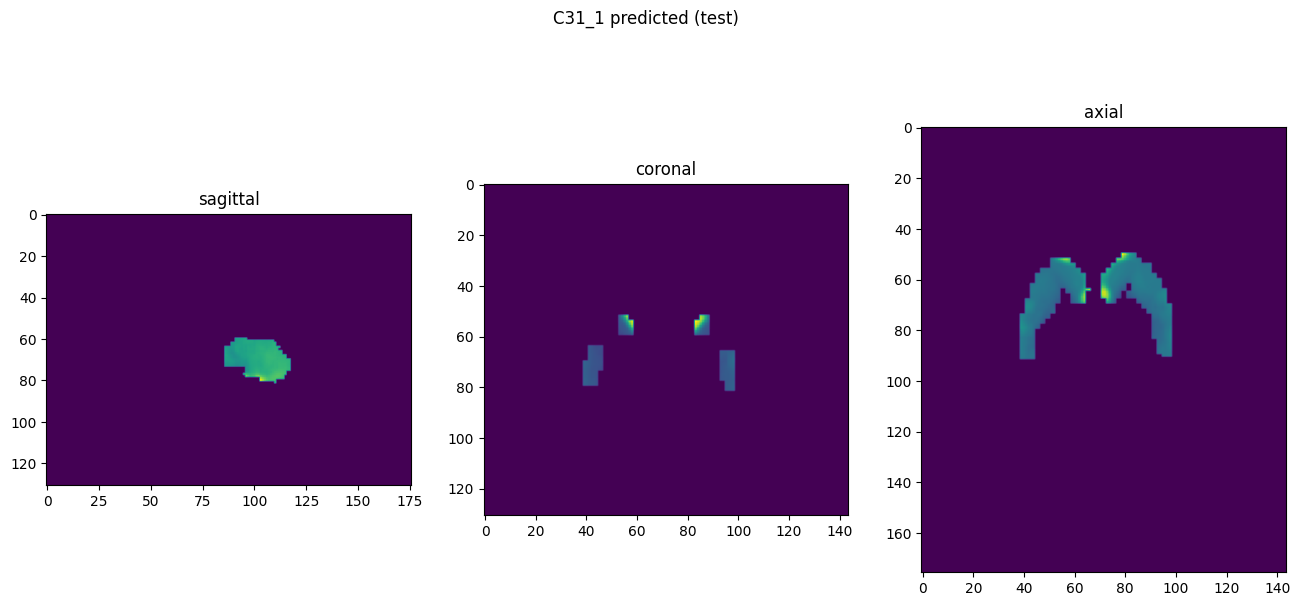

In [10]:
showResults(model, gen, threshold=None, background=False)